In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fake-news/FakeNewsNet.csv


In [2]:
import numpy as np
import pandas as pd

# Step - 1: EDA

In [3]:
df = pd.read_csv("/kaggle/input/fake-news/FakeNewsNet.csv")
df.head(5)

,title,news_url,source_domain,tweet_num,real
0,Kandi Burruss Explodes Over Rape Accusation on...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,42,1
1,People's Choice Awards 2018: The best red carp...,https://www.today.com/style/see-people-s-choic...,www.today.com,0,1
2,Sophia Bush Sends Sweet Birthday Message to 'O...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,63,1
3,Colombian singer Maluma sparks rumours of inap...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,20,1
4,Gossip Girl 10 Years Later: How Upper East Sid...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,38,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23196 entries, 0 to 23195
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   title          23196 non-null  object
 1   news_url       22866 non-null  object
 2   source_domain  22866 non-null  object
 3   tweet_num      23196 non-null  int64 
 4   real           23196 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 906.2+ KB


In [5]:
df.isnull().sum()

title              0
news_url         330
source_domain    330
tweet_num          0
real               0
dtype: int64

In [6]:
# Check the shape of dataset (rows, columns)
df.shape

(23196, 5)

In [7]:
# Look at all the columns names
df.columns.tolist()

['title', 'news_url', 'source_domain', 'tweet_num', 'real']

In [8]:
 # Look at unique values for each colum to find the target
for col in df.columns:
    print(f"\n Column:{col}")
    print(df[col].unique()[:1]) # This shows the first 1 unique values


 Column:title
["Kandi Burruss Explodes Over Rape Accusation on 'Real Housewives of Atlanta' Reunion (Video)"]

 Column:news_url
['http://toofab.com/2017/05/08/real-housewives-atlanta-kandi-burruss-rape-phaedra-parks-porsha-williams/']

 Column:source_domain
['toofab.com']

 Column:tweet_num
[42]

 Column:real
[1]


# Step - 2: Preprocessing

In [9]:
df.isnull().sum()

title              0
news_url         330
source_domain    330
tweet_num          0
real               0
dtype: int64

In [10]:
# Drop the "news_url"
df = df.drop("news_url", axis =1)

In [11]:
# Handle the missing values in source_domain. replace with "Unkown"
df['source_domain'] = df['source_domain'].fillna("Unknown")

In [12]:
# Importaing preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [13]:
# Identify columns Types
text_col = 'title' # Test Features
cat_col = 'source_domain'
num_col = 'tweet_num'

In [14]:
# Define Transformers for each column
text_transformer = TfidfVectorizer(max_features=5000,stop_words='english') # Limit vocab size
cat_transformer = OneHotEncoder(handle_unknown='ignore')
num_transformer = StandardScaler()

In [15]:
# Build a ColumnTransformer to apply different preprocessing to each type
preprocessor = ColumnTransformer(
    transformers=[
        ("text", text_transformer, text_col),
        ("cat", cat_transformer, [cat_col]),
        ("num", num_transformer, [num_col])
    ]
)

In [16]:
# Define features and target
X = df.drop("real", axis = 1)
y = df['real']

In [17]:
# Train-test split
X_train , X_test,y_train ,y_test = train_test_split(
    X,y, test_size=0.2 , random_state =42, stratify= y
)

# Step-3: Build & Train Logistic Regression Baseline

In [18]:
# Import Logistic Regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score , precision_score , recall_score, f1_score,roc_auc_score

In [19]:
# Create a pipeline that first perprocessor the data, then applies logisticc Regression
log_reg_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model",LogisticRegression(max_iter=1000, random_state=42))
])

In [20]:
# Train the pipeline on training data
log_reg_pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  TfidfVectorizer(max_features=5000,
                                                                  stop_words='english'),
                                                  'title'),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['source_domain']),
                                                 ('num', StandardScaler(),
                                                  ['tweet_num'])])),
                ('model', LogisticRegression(max_iter=1000, random_state=42))])

In [21]:
# Make predictions on the test data
y_pred = log_reg_pipeline.predict(X_test)
y_pred_proba=log_reg_pipeline.predict_proba(X_test)[:,1]

In [22]:
# Model performace
print("📊 Logistic Regression Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))

📊 Logistic Regression Performance:
Accuracy: 0.8713362068965518
Precision: 0.8783359497645212
Recall: 0.9621668099742047
F1 Score: 0.9183422240459582
ROC-AUC: 0.9070448292374271


# Step 4: Random Forest Classifier

In [23]:
# import random forest
from sklearn.ensemble import RandomForestClassifier


In [24]:
# Build pipeline - pewpeocessor + Random Forest
rf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=200,      # number of trees in the forest
        max_depth=20,          # limit tree depth (to avoid overfitting)
        random_state=42,
        n_jobs=-1         
    ))
])

In [25]:
# train model
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  TfidfVectorizer(max_features=5000,
                                                                  stop_words='english'),
                                                  'title'),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['source_domain']),
                                                 ('num', StandardScaler(),
                                                  ['tweet_num'])])),
                ('model',
                 RandomForestClassifier(max_depth=20, n_estimators=200,
                                        n_jobs=-1, random_state=42))])

In [26]:
# Predictions
y_pred_rf = rf_pipeline.predict(X_test)
y_pred_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]

In [27]:
#     Evaluation
print("📊 Random Forest Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("F1 Score:", f1_score(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba_rf))

📊 Random Forest Performance:
Accuracy: 0.7922413793103448
Precision: 0.7854397467782048
Recall: 0.9957007738607051
F1 Score: 0.878159757330637
ROC-AUC: 0.8767982232355429


# Step 4: XGBoost

In [28]:
# import XGBoost
from xgboost import XGBClassifier

In [29]:
# Build pipeline = preprocessor + XGboost
xgb_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),                       # Preprocessing step
    ("model", XGBClassifier(
        n_estimators=300,     # number of trees
        max_depth=8,          # tree depth
        learning_rate=0.1,    # step size shrinkage
        subsample=0.8,        # fraction of data for training
        colsample_bytree=0.8, # fraction of features for training
        random_state=42,
        n_jobs=-1,
        use_label_encoder=False,
        eval_metric="logloss" # avoid warnings
    ))
])

In [30]:
# Train
xgb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  TfidfVectorizer(max_features=5000,
                                                                  stop_words='english'),
                                                  'title'),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['source_domain']),
                                                 ('num', StandardScaler(),
                                                  ['tweet_num'])])),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=8, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=300, n_jobs=-1,
                               num_parallel_tree=None, random_state=42, ...))])

In [31]:
#  Predictions
y_pred_xgb = xgb_pipeline.predict(X_test)
y_pred_proba_xgb = xgb_pipeline.predict_proba(X_test)[:, 1]

In [32]:
#  Evaluation
print("📊 XGBoost Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Precision:", precision_score(y_test, y_pred_xgb))
print("Recall:", recall_score(y_test, y_pred_xgb))
print("F1 Score:", f1_score(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba_xgb))

📊 XGBoost Performance:
Accuracy: 0.8866379310344827
Precision: 0.9015993494171862
Recall: 0.9532817426196618
F1 Score: 0.9267205349679577
ROC-AUC: 0.9256164153991232


 # Step 5: Comparison Table for All Models

In [33]:
#  Collect metrics into a dictionary
results = {
    "Model": ["Logistic Regression", "Random Forest", "XGBoost"],
    "Accuracy": [
        accuracy_score(y_test, y_pred),       # logistic regression
        accuracy_score(y_test, y_pred_rf),    # random forest
        accuracy_score(y_test, y_pred_xgb)    # xgboost
    ],
    "Precision": [
        precision_score(y_test, y_pred),
        precision_score(y_test, y_pred_rf),
        precision_score(y_test, y_pred_xgb)
    ],
    "Recall": [
        recall_score(y_test, y_pred),
        recall_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_xgb)
    ],
    "F1 Score": [
        f1_score(y_test, y_pred),
        f1_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_xgb)
    ],
    "ROC-AUC": [
        roc_auc_score(y_test, y_pred_proba),
        roc_auc_score(y_test, y_pred_proba_rf),
        roc_auc_score(y_test, y_pred_proba_xgb)
    ]
}

In [34]:
#  Convert results into a DataFrame
results_df = pd.DataFrame(results)

In [35]:
# S Display comparison table
print("📊 Model Comparison Table")
print(results_df)

📊 Model Comparison Table
                 Model  Accuracy  Precision    Recall  F1 Score   ROC-AUC
0  Logistic Regression  0.871336   0.878336  0.962167  0.918342  0.907045
1        Random Forest  0.792241   0.785440  0.995701  0.878160  0.876798
2              XGBoost  0.886638   0.901599  0.953282  0.926721  0.925616


# Step 6: Confusion Matrix Heatmap for XGBoost

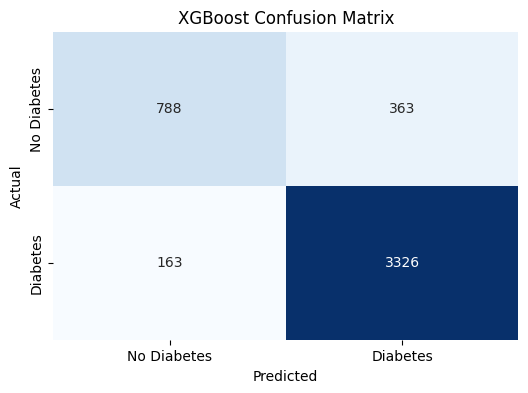

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_xgb)

# Plot heatmap
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No Diabetes", "Diabetes"],
            yticklabels=["No Diabetes", "Diabetes"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("XGBoost Confusion Matrix")
plt.show()
